In [67]:
from os import chmod

import numpy as np
import pandas as pd
from exceptiongroup import print_exc
from scipy.stats import truncnorm, norm
from six import print_


# Conditional skills
def conditional_skills(mu_s1, mu_s2, sigma_s1, sigma_s2, t, outcome_var):
    mean_s = np.array([mu_s1, mu_s2])
    cov_s = np.array([[sigma_s1, 0],
                      [0, sigma_s2]])  # Covariance matrix with S_12 and S_21
    outcome_mean = mu_s1 - mu_s2
    outcome_var = sigma_s1 + sigma_s2 + outcome_var # Outcome variance

    # Conditional mean update
    mean_cond = mean_s + (t - outcome_mean) / outcome_var * np.array([sigma_s1, -sigma_s2])

    # Conditional covariance update
    cov_cond = cov_s - np.outer([sigma_s1, -sigma_s2], [sigma_s1, -sigma_s2]) / outcome_var
  
    return mean_cond, cov_cond


# Conditional outcome (truncated Gaussian)
def conditional_outcome(mu_s1, mu_s2, result, outcome_var): #changed so that it only depends on mu_s1 and mu_s2
    mean_diff = mu_s1 - mu_s2
    std_diff = outcome_var

    # Set truncation limits based on match outcome
    if result == 1:
        a, b = 0, np.inf  # Truncate for team 1 winning
    else:
        a, b = -np.inf, 0  # Truncate for team 2 winning

    # Create truncated Gaussian distribution
    trunc_gauss_dist = truncnorm(a=(a - mean_diff) / std_diff, b=(b - mean_diff) / std_diff, loc=mean_diff, scale=std_diff)
    
    return a,b



# Marginal probability that team 1 wins
def marginal_p_y1(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t):
    mu_diff = mu_s1 - mu_s2
    sigma_diff = np.sqrt(sigma_s1 + sigma_s2 + sigma_t)
    p_y1 = 1 - norm.cdf(0, loc=mu_diff, scale=sigma_diff)
    return p_y1

#print("marginal_y =", marginal_p_y1(1, -1, 1, 4,5)) #Probability p(t > 0), e.g player 1 wins. Where t is the Gaussian random variable obtained by marginalizing out s1 and s2 from p(t, s1, s2).


#Gibbs sampler

def gibbs_sampler(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter):
    s1_samples = np.zeros(n_iter)
    s2_samples = np.zeros(n_iter)
    t_samples = np.zeros(n_iter)
    y_samples = np.zeros(n_iter)
    s1, s2 = mu_s1, mu_s2
    
    #initializing the truncation limits
    a, b = conditional_outcome(s1, s2, 1, sigma_t)
    t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t)
    
    for i in range(n_iter):
        y = 1 
        mean_cond, cov_cond = conditional_skills(mu_s1, mu_s2,sigma_s1, sigma_s2, t, sigma_t) # P(s1, s2 | t)
        s1, s2 = np.random.multivariate_normal(mean_cond, cov_cond)
        s1_samples[i] = s1
        s2_samples[i] = s2
        a, b = conditional_outcome(s1, s2, y, sigma_t)
        t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t) #P(t | s1, s2 ,y)
        t_samples[i] = t
        y_samples[i] = y

    return s1_samples, s2_samples, t_samples

n_iter = 100 
mu_s1 = 25 # Initial mean for player 1
mu_s2 = 25 # Initial mean for player 2
sigma_s1 = 8.33 # Variance for player 1
sigma_s2 = 8.33 # Variance for player 2
sigma_t = 25/6 # Outcome variance

s1_samples, s2_samples, t_samples = gibbs_sampler(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter)

# Step 1: Calculate the means
mean_s1 = np.mean(s1_samples)
mean_s2 = np.mean(s2_samples)
mean_t = np.mean(t_samples)

# Step 2: Calculate the variances
var_s1 = np.var(s1_samples, ddof=1)
var_s2 = np.var(s2_samples, ddof=1)
var_t = np.var(t_samples, ddof=1)

    
        
            

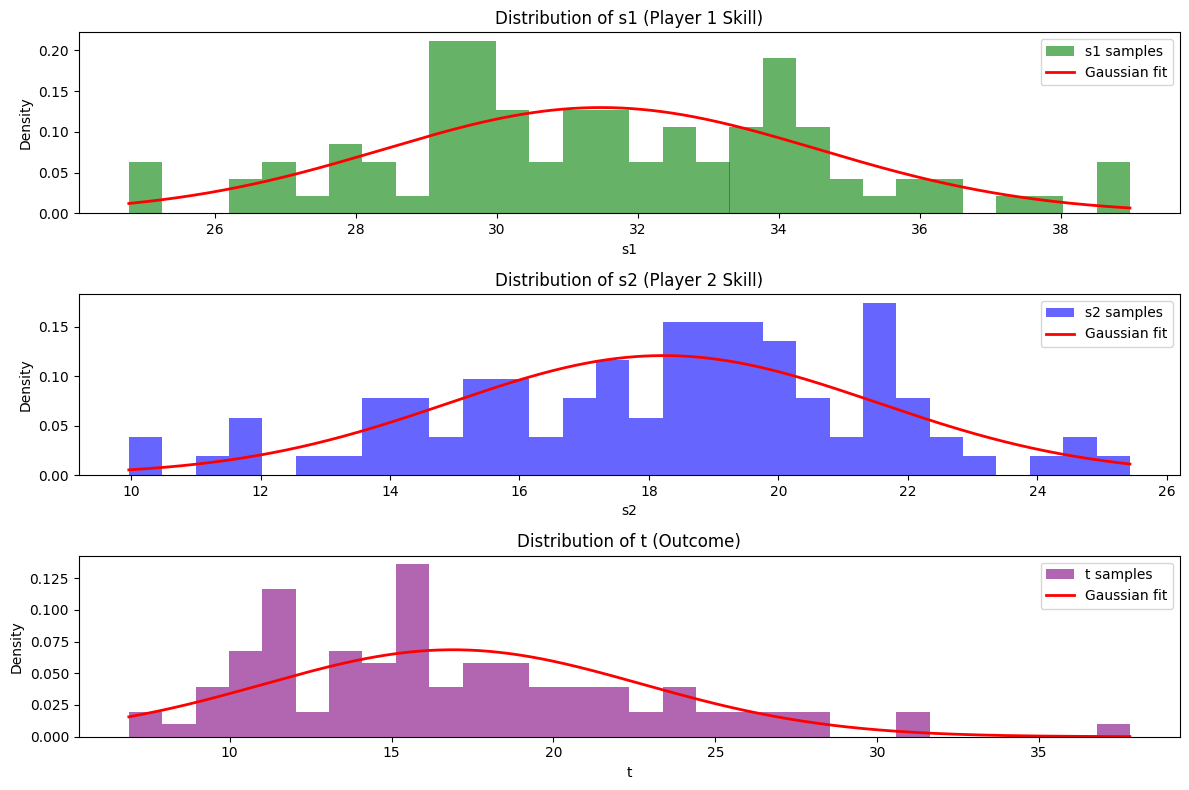

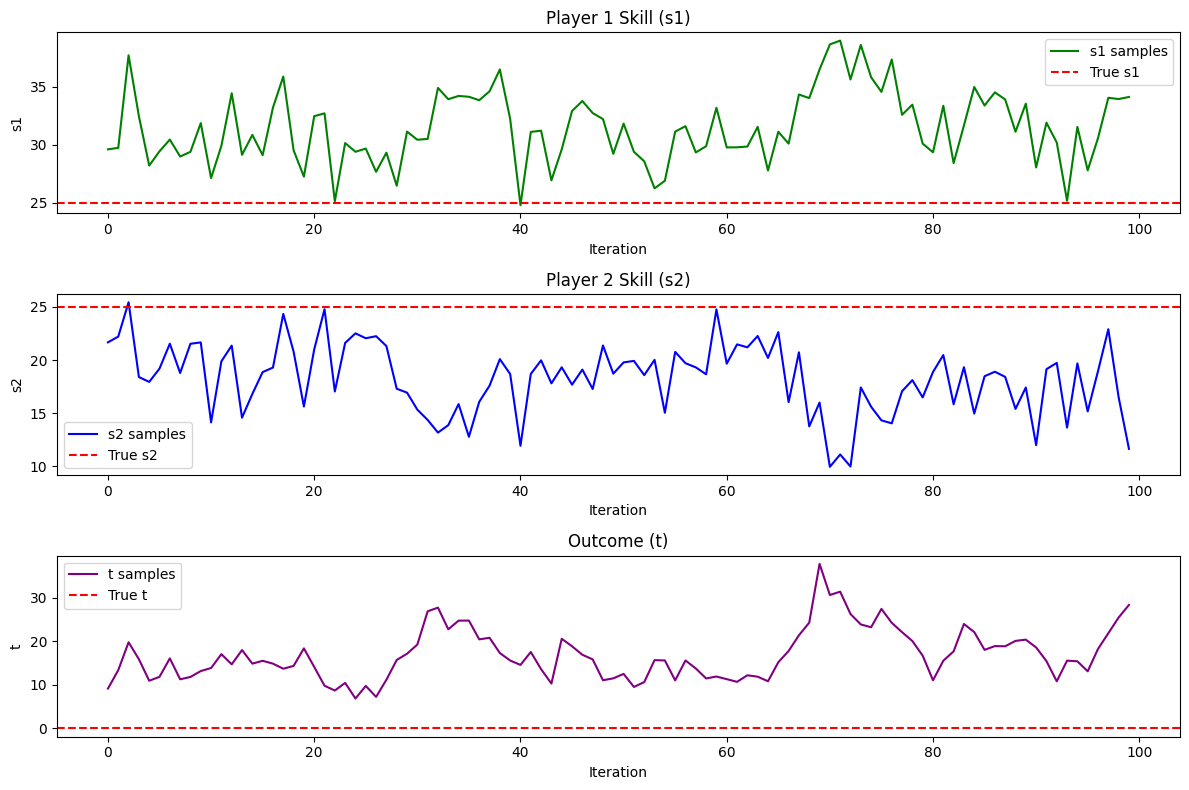

In [68]:
# Plot the samples
import matplotlib.pyplot as plt


# Step 3: Plot the histograms with fitted Gaussian curves
x_s1 = np.linspace(min(s1_samples), max(s1_samples), 1000)
x_s2 = np.linspace(min(s2_samples), max(s2_samples), 1000)
x_t = np.linspace(min(t_samples), max(t_samples), 1000)

# Plot s1 samples
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.hist(s1_samples, bins=30, density=True, alpha=0.6, color='g', label="s1 samples")
plt.plot(x_s1, norm.pdf(x_s1, mean_s1, np.sqrt(var_s1)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of s1 (Player 1 Skill)')
plt.xlabel('s1')
plt.ylabel('Density')
plt.legend()

# Plot s2 samples
plt.subplot(3, 1, 2)
plt.hist(s2_samples, bins=30, density=True, alpha=0.6, color='b', label="s2 samples")
plt.plot(x_s2, norm.pdf(x_s2, mean_s2, np.sqrt(var_s2)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of s2 (Player 2 Skill)')
plt.xlabel('s2')
plt.ylabel('Density')
plt.legend()

# Plot t samples
plt.subplot(3, 1, 3)
plt.hist(t_samples, bins=30, density=True, alpha=0.6, color='purple', label="t samples")
plt.plot(x_t, norm.pdf(x_t, mean_t, np.sqrt(var_t)), 'r-', lw=2, label="Gaussian fit")
plt.title('Distribution of t (Outcome)')
plt.xlabel('t')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(s1_samples, color='g', label="s1 samples")
plt.axhline(y=mu_s1, color='r', linestyle='--', label="True s1")
plt.title('Player 1 Skill (s1)')
plt.xlabel('Iteration')
plt.ylabel('s1')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(s2_samples, color='b', label="s2 samples")
plt.axhline(y=mu_s2, color='r', linestyle='--', label="True s2")
plt.title('Player 2 Skill (s2)')
plt.xlabel('Iteration')
plt.ylabel('s2')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t_samples, color='purple', label="t samples")
plt.axhline(y=mu_s1 - mu_s2, color='r', linestyle='--', label="True t")
plt.title('Outcome (t)')
plt.xlabel('Iteration')
plt.ylabel('t')
plt.legend()

plt.tight_layout()

plt.show()

In [69]:
def gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, result):
    s1_samples = np.zeros(n_iter)
    s2_samples = np.zeros(n_iter)
    t_samples = np.zeros(n_iter)
    y_samples = np.zeros(n_iter)
    s1, s2 = mu_s1, mu_s2

    #initializing the truncation limits
    a, b = conditional_outcome(s1, s2, result, sigma_t)
    t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t)

    for i in range(n_iter):
        y = result 
        mean_cond, cov_cond = conditional_skills(mu_s1, mu_s2,sigma_s1, sigma_s2, t, sigma_t) # P(s1, s2 | t)
        s1, s2 = np.random.multivariate_normal(mean_cond, cov_cond)
        s1_samples[i] = s1
        s2_samples[i] = s2
        a, b = conditional_outcome(s1, s2, y, sigma_t)
        t = truncnorm.rvs(a, b, loc=s1 - s2, scale= sigma_t) #P(t | s1, s2 ,y)
        t_samples[i] = t
        y_samples[i] = y

    return s1_samples, s2_samples, t_samples

In [70]:
import pandas as pd

# Load the CSV data into a pandas DataFrame
data = 'SerieA.csv'
df = pd.read_csv(data)

# Filter out matches where the score is a draw
df_filtered = df[df['score1'] != df['score2']].copy()  # Use .copy() to avoid the warning

# Create a new 'win' column: 1 if Team 1 won, -1 if Team 1 lost
df_filtered.loc[:, 'win'] = df_filtered.apply(lambda row: 1 if row['score1'] > row['score2'] else -1, axis=1)

# Display the filtered DataFrame with the 'win' column



In [71]:

print(df_filtered)


     yyyy-mm-dd  HH:MM     team1     team2  score1  score2  win
0    2018-08-18  18:00    Chievo  Juventus       2       3   -1
1    2018-08-18  20:30     Lazio    Napoli       1       2   -1
2    2018-08-19  18:00    Torino      Roma       0       1   -1
3    2018-08-19  20:30  Sassuolo     Inter       1       0    1
5    2018-08-19  20:30    Empoli  Cagliari       2       0    1
..          ...    ...       ...       ...     ...     ...  ...
374  2019-05-26  20:30      Spal     Milan       2       3   -1
375  2019-05-26  20:30      Roma     Parma       2       1    1
376  2019-05-26  20:30     Inter    Empoli       2       1    1
378  2019-05-26  20:30  Cagliari   Udinese       1       2   -1
379  2019-05-26  20:30  Atalanta  Sassuolo       3       1    1

[272 rows x 7 columns]


In [72]:
#Initialize skills for every team
skills = {}
for team in df_filtered['team1'].unique():
    skills[team] = (25, 8.33)
for team in df_filtered['team2'].unique():
    skills[team] = (25, 8.33) 

In [73]:
print(skills)

{'Chievo': (25, 8.33), 'Lazio': (25, 8.33), 'Torino': (25, 8.33), 'Sassuolo': (25, 8.33), 'Empoli': (25, 8.33), 'Bologna': (25, 8.33), 'Atalanta': (25, 8.33), 'Juventus': (25, 8.33), 'Napoli': (25, 8.33), 'Spal': (25, 8.33), 'Udinese': (25, 8.33), 'Genoa': (25, 8.33), 'Fiorentina': (25, 8.33), 'Milan': (25, 8.33), 'Parma': (25, 8.33), 'Sampdoria': (25, 8.33), 'Inter': (25, 8.33), 'Frosinone': (25, 8.33), 'Roma': (25, 8.33), 'Cagliari': (25, 8.33)}


In [74]:
#run the Gibbs sampler for every match
n_iter = 100 
sigma_t = 25/6

for index, row in df_filtered.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    result = row['win']
    mu_s1, sigma_s1 = skills[team1]
    mu_s2, sigma_s2 = skills[team2]
    s1_samples, s2_samples, t_samples = gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, result)
    skills[team1] = (np.mean(s1_samples), np.var(s1_samples, ddof=1))
    skills[team2] = (np.mean(s2_samples), np.var(s2_samples, ddof=1))
    
    


In [75]:
# Sorting the dictionary by the first value in the tuple (in ascending order)
sorted_data = sorted(skills.items(), key=lambda x: x[1][0])


# Print the sorted result
for team, values in sorted_data:
    print(f"{team}: {values}")

Chievo: (np.float64(-1407.638099692492), np.float64(4111.878349650222))
Parma: (np.float64(-782.9666798620158), np.float64(7365.47457863048))
Genoa: (np.float64(-745.888337484984), np.float64(4588.402858020361))
Sassuolo: (np.float64(-339.00047188367097), np.float64(6530.194302634079))
Empoli: (np.float64(-322.286805257761), np.float64(4623.496325341377))
Spal: (np.float64(-240.09752543599595), np.float64(4532.915961043864))
Cagliari: (np.float64(-223.65494046448575), np.float64(5729.83108854077))
Sampdoria: (np.float64(-78.70161929315672), np.float64(3557.616417217243))
Frosinone: (np.float64(-40.97850309977598), np.float64(265.6320420555323))
Fiorentina: (np.float64(24.62907419691318), np.float64(19.78686049883245))
Bologna: (np.float64(183.3870603348192), np.float64(5121.051705850938))
Udinese: (np.float64(297.4139640598811), np.float64(5064.304325297589))
Lazio: (np.float64(399.5098765030738), np.float64(3744.3496394851363))
Roma: (np.float64(686.2412640960584), np.float64(3979.324

In [76]:
# Load the CSV data into a pandas DataFrame
data = 'SerieA.csv'
df_random = pd.read_csv(data)

# Shuffle the DataFrame
# Filter out matches where the score is a draw
df_random = df_random[df_random['score1'] != df_random['score2']].copy()  # Use .copy() to avoid the warning

# Create a new 'win' column: 1 if Team 1 won, -1 if Team 1 lost
df_random.loc[:, 'win'] = df_random.apply(lambda row: 1 if row['score1'] > row['score2'] else -1, axis=1)
df_shuffled = df_random.sample(frac=1).reset_index(drop=True)

# Display the shuffled DataFrame

In [77]:
print(df_shuffled)

     yyyy-mm-dd  HH:MM      team1      team2  score1  score2  win
0    2018-12-26  15:00  Sampdoria     Chievo       2       0    1
1    2019-04-20  15:00     Empoli       Spal       2       4   -1
2    2018-08-19  18:00     Torino       Roma       0       1   -1
3    2019-05-26  15:00     Torino      Lazio       3       1    1
4    2019-03-08  20:30   Juventus    Udinese       4       1    1
..          ...    ...        ...        ...     ...     ...  ...
267  2018-11-24  20:30      Inter  Frosinone       3       0    1
268  2018-12-09  15:00     Empoli    Bologna       2       1    1
269  2019-05-12  18:00       Spal     Napoli       1       2   -1
270  2018-09-23  12:30     Torino     Napoli       1       3   -1
271  2018-12-29  12:30   Juventus  Sampdoria       2       1    1

[272 rows x 7 columns]


In [78]:
#Initialize skills for every team
skills = {}
for team in df_shuffled['team1'].unique():
    skills[team] = (25, 8.33)
for team in df_shuffled['team2'].unique():
    skills[team] = (25, 8.33)

In [79]:
#run the Gibbs sampler for every match
n_iter = 100
sigma_t = 25/6

for index, row in df_shuffled.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    result = row['win']
    mu_s1, sigma_s1 = skills[team1]
    mu_s2, sigma_s2 = skills[team2]
    s1_samples, s2_samples, t_samples = gibbs_sampler_result(mu_s1, mu_s2, sigma_s1, sigma_s2, sigma_t, n_iter, result)
    skills[team1] = (np.mean(s1_samples), np.var(s1_samples, ddof=1))
    skills[team2] = (np.mean(s2_samples), np.var(s2_samples, ddof=1))





In [80]:
# Sorting the dictionary by the first value in the tuple (in ascending order)
sorted_data = sorted(skills.items(), key=lambda x: x[1][0])


# Print the sorted result
for team, values in sorted_data:
    print(f"{team}: {values}")

Genoa: (np.float64(-1054.3481494034745), np.float64(4640.764288773317))
Frosinone: (np.float64(-869.3657089053843), np.float64(6579.817693891881))
Chievo: (np.float64(-589.6395754060127), np.float64(3688.616075336203))
Sassuolo: (np.float64(-454.60231631674174), np.float64(5519.346885761271))
Empoli: (np.float64(-428.6536710533131), np.float64(4661.219719071442))
Cagliari: (np.float64(-292.2754611207685), np.float64(6318.478420504394))
Bologna: (np.float64(-260.43274657353015), np.float64(3787.1519477744846))
Parma: (np.float64(-202.48245109008374), np.float64(2668.6516119779153))
Fiorentina: (np.float64(-46.50767060426594), np.float64(7392.661061825311))
Spal: (np.float64(-20.612468794470452), np.float64(3806.1811982952395))
Sampdoria: (np.float64(53.59101951278846), np.float64(2695.2007558560595))
Udinese: (np.float64(116.80746210164462), np.float64(5107.806933838976))
Milan: (np.float64(148.59524326979962), np.float64(287.5973119081936))
Roma: (np.float64(338.90504528191644), np.flo